## Критерий Фишера

Необходимо провести дисперсионный анализ с применением критерия Фишера по данным регистраторов для одного сигнала. Определить области однородности сигнала, переходные области, шум/фон. Длину сигнала взять равной 1024.

Подключаем все нужные библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

Функция, которая открывает файл wave_ampl.txt и считывает данные

In [2]:
def read_signal(filename):
    data = []
    # открываем файл в формате чтения
    with open(filename, 'r') as f:
        for line in f.readlines():
            # если в прочитанных строках содержатся скобочки, удаляем их
            remove_dirst_str = line.replace("[", "")
            remove_next_str = remove_dirst_str.replace("]", "")
            data.append(remove_next_str.split(", "))

    # переводим данные в вещественный формат
    data_float_format = []
    for item in data:
        data_float_format.append([float(x) for x in item])

    new_data = np.asarray(data_float_format)
    # изменяем размер массива
    data = np.reshape(new_data, (new_data.shape[1] // 1024, 1024))
    
    return data[0]


Функция, отрисовывающая сигнал

In [57]:
def draw_signal(signal, title):
    plt.title(title)
    plt.plot(range(len(signal)), signal, 'deepskyblue')
    plt.grid()
    plt.show()
    plt.savefig("signal_plot.jpg")

Функция, отрисовывающая гистограмму

In [58]:
def draw_hist(signal):
    bin = int(math.log2(len(signal) + 1))
    hist = plt.hist(signal, bins=bin, color='deepskyblue')
    plt.grid()
    plt.title("Гистограмма сигнала")
    plt.savefig("hist.jpg")
    plt.show()
    return bin, hist

Функция, определяющая в сигнале переходы, шум, сигнал

In [39]:
def get_areas(signal):
    bin = int(math.log2(len(signal) + 1))
    hist = plt.hist(signal, bins=bin)
    plt.title("Histogram")
    
    count = []
    start = []
    finish = []
    types = [0] * bin

    for i in range(bin):
        count.append(hist[0][i])
        start.append(hist[1][i])
        finish.append(hist[1][i + 1])

    sortedHist = sorted(count)
    repeat = 0
    for i in range(bin):
        for j in range(bin):
            if sortedHist[len(sortedHist) - 1 - i] == count[j]:
                if repeat == 0:
                    types[j] = "фон"
                elif repeat == 1:
                    types[j] = "сигнал"
                else:
                    types[j] = "переход"
                repeat += 1

    return start, finish, types

Функция, конвертирующая данные

In [40]:
def get_converted_data(signal, start, finish, types):
    signal_types = [0] * len(signal)
    zones = []
    zones_type = []

    for i in range(len(signal)):
        for j in range(len(types)):
            if (signal[i] >= start[j]) and (signal[i] <= finish[j]):
                signal_types[i] = types[j]

    currType = signal_types[0]
    start = 0
    for i in range(len(signal_types)):
        if currType != signal_types[i]:
            finish = i
            zones_type.append(currType)
            zones.append([start, finish])
            start = finish
            currType = signal_types[i]

    if currType != zones_type[len(zones_type) - 1]:
        zones_type.append(currType)
        zones.append([finish, len(signal) - 1])

    return zones, zones_type, get_signal_data(signal, zones)

In [41]:
def get_signal_data(signal, zones):
    signal_data = list()
    for borders in zones:
        data_part = list()
        for j in range(borders[0], borders[1]):
            data_part.append(signal[j])
        signal_data.append(data_part)
    return signal_data

Функция, отрисовывающая разделённые области

In [42]:
def draw_areas(signal_data, area_data, types, title):
    plt.title(title)
    plt.ylim([-0.5, 0])
    for i in range(len(area_data)):
        if types[i] == "фон":
            color_ = 'y'
        if types[i] == "сигнал":
            color_ = 'r'
        if types[i] == "переход":
            color_ = 'g'
        print(types)
        plt.plot([num for num in range(area_data[i][0], area_data[i][1], 1)], signal_data[i], color=color_, label=types[i])
    plt.grid()
    plt.legend()
    plt.show()

Блок кода, вычисляющий оценку Фишера

In [43]:
def get_inter_group_D(signal):
    summ = 0.0
    mean = np.empty(signal.shape[0])
    for i in range(len(signal)):
        mean[i] = np.mean(signal[i])
    meanMean = np.mean(mean)

    for i in range(len(mean)):
        summ += (mean[i] - meanMean) ** 2
    summ /= (signal.shape[0] - 1)

    return len(signal) * summ


def get_intar_group_D(signal):
    result = 0.0
    for i in range(signal.shape[0]):
        mean = np.mean(signal[i])
        summ = 0.0
        for j in range(signal.shape[1]):
            summ += (signal[i][j] - mean) ** 2
        summ /= (signal.shape[0] - 1)
        result += summ

    return result / signal.shape[0]


def get_F(signal, k):
    newSizeY = int(signal.size / k)
    newSizeX = k
    print("k = " + str(k))
    splitData = np.reshape(signal, (newSizeX, newSizeY))
    interGroup = get_inter_group_D(splitData)
    print("Inter = " + str(interGroup))
    intraGroup = get_intar_group_D(splitData)
    print("Intar = " + str(intraGroup))
    print("F = " + str(interGroup / intraGroup))
    return interGroup / intraGroup


def get_K(num):
    i = 4
    while num % i != 0:
        i += 1
    return i


def get_Fisher(signal, area_data):
    fishers = []
    for i in range(len(area_data)):
        start = area_data[i][0]
        finish = area_data[i][1]
        k = get_K(finish - start)
        while k == finish - start:
            finish += 1
            k = get_K(finish - start)
        fishers.append(get_F(signal[start:finish], int(k)))
    return fishers

Блок вызова функций, написанных ранее

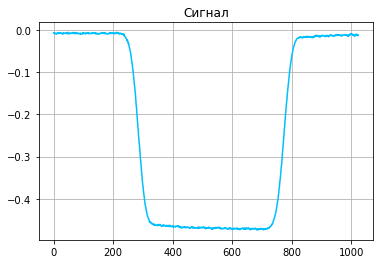

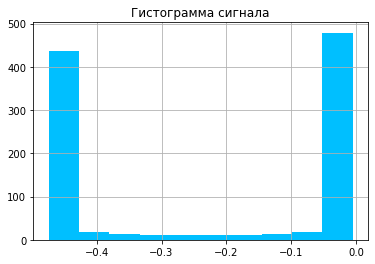

k = 6
Inter = 0.00010475856345700058
Intar = 0.000216008479603863
F = 0.484974310495203
k = 6
Inter = 0.1036660945206072
Intar = 0.0006086543661478382
F = 170.32013616645506
k = 19
Inter = 0.0006849222007922233
Intar = 1.640848685419312e-05
F = 41.74194774195125
k = 5
Inter = 0.08749951290796942
Intar = 0.0013511772233167946
F = 64.75798392543985
k = 4
Inter = 7.540779174496053e-05
Intar = 0.0003486853901846047
F = 0.21626312391533625
[0.484974310495203, 170.32013616645506, 41.74194774195125, 64.75798392543985, 0.21626312391533625]
['фон', 'переход', 'сигнал', 'переход', 'фон']
['фон', 'переход', 'сигнал', 'переход', 'фон']
['фон', 'переход', 'сигнал', 'переход', 'фон']
['фон', 'переход', 'сигнал', 'переход', 'фон']
['фон', 'переход', 'сигнал', 'переход', 'фон']


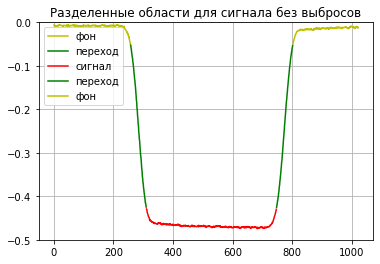

[[0, 258], [258, 311], [311, 748], [748, 803], [803, 1023]]


In [59]:
signal = read_signal("wave_ampl.txt")
draw_signal(signal, 'Сигнал')
draw_hist(signal)
start, finish, types = get_areas(signal)
zones, zones_types, signal_data = get_converted_data(signal, start, finish, types)
print(get_Fisher(signal, zones))
types = ['фон', 'переход', 'сигнал', 'переход', 'фон']
draw_areas(signal_data, zones, types, "Разделенные области для сигнала без выбросов")
print(zones)